# Mesh2d refine casulli based on depths

In [8]:
import matplotlib.pyplot as plt
from pathlib import Path

plt.close("all")
import xarray as xr
import numpy as np
import meshkernel
from meshkernel import (
    MakeGridParameters,
    MeshKernel,
    GeometryList,
    GriddedSamples,
    ProjectionType,
    MeshRefinementParameters,
    RefinementType,
    InterpolationType
)

mk_version = meshkernel.__version__

In [9]:
mk = MeshKernel(ProjectionType.CARTESIAN)

x_start, x_end = 0, 10000
y_min, y_max = 0, 10000
num_samples = 100 

makeGridParameters = MakeGridParameters()
makeGridParameters.origin_x = x_start
makeGridParameters.origin_y = y_min
makeGridParameters.upper_right_x = x_end
makeGridParameters.upper_right_y = y_max
makeGridParameters.block_size_x = 1000
makeGridParameters.block_size_y = 1000

mk.mesh2d_make_rectangular_mesh_on_extension(makeGridParameters)

In [10]:
## Plot starting mesh

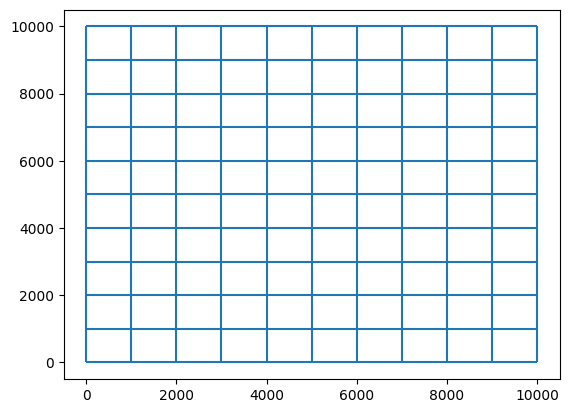

In [11]:
mesh2d_not_refined = mk.mesh2d_get()
fig, ax = plt.subplots()
mesh2d_not_refined.plot_edges(ax)

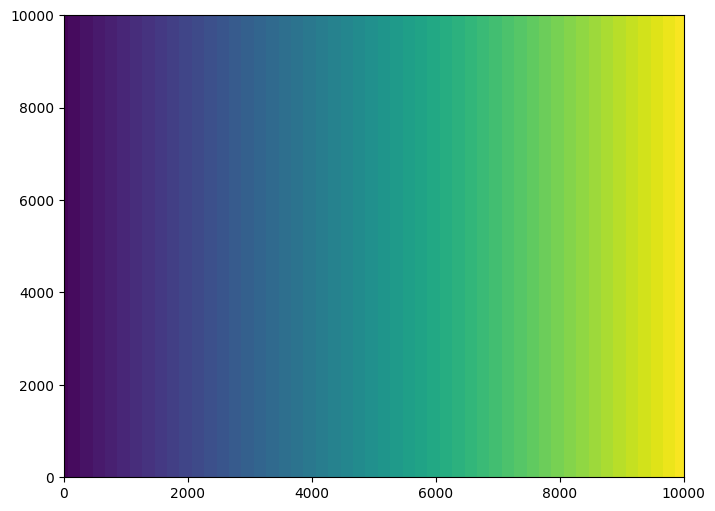

In [12]:
x_grid, y_grid = np.meshgrid(np.linspace(x_start, x_end, num_samples), 
                             np.linspace(y_min, y_max, num_samples))
values = np.array(np.interp(x_grid, [x_start, x_end], [-10.0, 5.0]), dtype=np.double)
plt.figure(figsize=(8, 6))
plt.contourf(x_grid, y_grid, values, levels=50)


In [13]:
x_coordinates= np.array(x_grid.flatten(), dtype=np.double)
y_coordinates = np.array(y_grid.flatten(), dtype=np.double)
values = np.array(values.flatten(), dtype=np.double)

samples = GeometryList(x_coordinates=x_coordinates,
                       y_coordinates=y_coordinates,
                       values=values)

property_id = mk.mkernel_set_property(ProjectionType.CARTESIAN,
                                      InterpolationType.AVERAGING,
                                      samples)

x_coordinates_pol = np.empty(0, dtype=np.double)
y_coordinates_pol = np.empty(0, dtype=np.double)
polygons = GeometryList(x_coordinates=x_coordinates_pol,
                        y_coordinates=y_coordinates_pol)

meshRefinementParameters = MeshRefinementParameters()
minimumRefinementDepth = 0.0
mk.mkernel_mesh2d_casulli_refinement_based_on_depths(polygons,
                                                     property_id,
                                                     meshRefinementParameters,
                                                     minimumRefinementDepth)

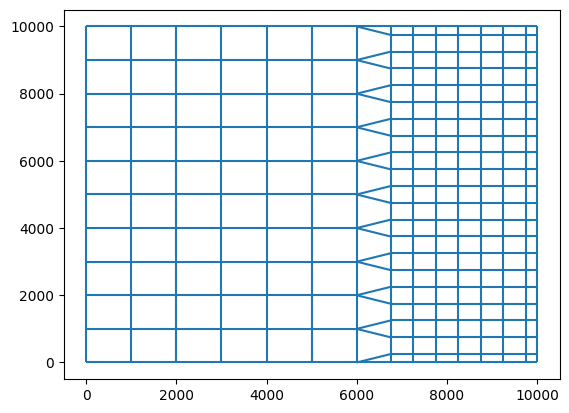

In [14]:
mesh2d_refined = mk.mesh2d_get()
fig, ax = plt.subplots()
mesh2d_refined.plot_edges(ax)

## Utility for reading samples

In [ ]:
def read_and_filter_samples(file_path, lower_left, upper_right):
    """
    Reads a text file of samples (lat, long, depth), filters samples within a bounding box.

    :param file_path: Path to the text file containing the data.
    :param lower_left: Tuple with (latitude, longitude) of the lower-left corner of the bounding box.
    :param upper_right: Tuple with (latitude, longitude) of the upper-right corner of the bounding box.
    :return: List of filtered samples as tuples (latitude, longitude, depth).
    """
    filtered_samples = []

    # Unpack bounding box corners
    ll_lat, ll_long = lower_left
    ur_lat, ur_long = upper_right

    try:
        with open(file_path, 'r') as file:
            for line in file:
                # Parse the line into latitude, longitude, and depth
                parts = line.strip().split('\t')
                if len(parts) != 3:
                    continue

                try:
                    lat, long, depth = map(float, parts)
                except ValueError:
                    continue

                # Check if the sample is within the bounding box
                if ll_lat <= lat <= ur_lat and ll_long <= long <= ur_long:
                    filtered_samples.append((lat, long, depth))

    except FileNotFoundError:
        print(f"Error: File {file_path} not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

    return filtered_samples

In [ ]:
input_file = 'stpete.xyz'
input_file_path = Path().absolute() / "data_examples" / input_file

lower_left_corner = (-82.79428, 28.00218)
upper_right_corner = (-82.76323, 28.02404)
# Read and filter the samples
filtered = read_and_filter_samples(input_file_path, lower_left_corner, upper_right_corner)

In [ ]:
## Eventually save the filtered window

In [ ]:
output_file = 'stpete_out.xyz'
input_file_path = Path().absolute() / "data_examples" / output_file
with open(input_file_path, 'w') as file:
    for sample in filtered:
        file.write(f"{sample[0]}\t{sample[1]}\t{sample[2]}\n")

### Generate regular grid

In [ ]:
lon_min, lon_max, lat_min, lat_max = -68.55, -67.9, 11.8, 12.6
dx = dy = 0.05
make_grid_parameters = MakeGridParameters(
    angle=0,
    origin_x=lon_min,
    origin_y=lat_min,
    upper_right_x=lon_max,
    upper_right_y=lat_max,
    block_size_x=dx,
    block_size_y=dy,
)

mk = MeshKernel(projection=ProjectionType.CARTESIAN)
mk.curvilinear_compute_rectangular_grid_on_extension(make_grid_parameters)
mk.curvilinear_convert_to_mesh2d()  # convert to ugrid/mesh2d

### Perform refinement

In [ ]:
gridded_samples = GriddedSamples(
    x_coordinates=lon_np, y_coordinates=lat_np, values=values_np
)

In [ ]:
mesh_refinement_parameters = MeshRefinementParameters(
    min_edge_size=300,  # always in meters
    refinement_type=RefinementType(1),  # Wavecourant/1,
    connect_hanging_nodes=True,  # set to False to do multiple refinement steps (e.g. for multiple regions)
    smoothing_iterations=2,
    max_courant_time=120,
)

In [ ]:
mk.mesh2d_refine_based_on_gridded_samples(
    gridded_samples=gridded_samples,
    mesh_refinement_params=mesh_refinement_parameters,
    use_nodal_refinement=True,
)

In [ ]:
fig, ax = plt.subplots()
mk.mesh2d_get().plot_edges(ax=ax, linewidth=1)